# Chess board recognition

Downloading the dataset and preparing the workspace

In [ ]:
!wget -O input.zip https://github.com/samryan18/chess-dataset/archive/refs/heads/master.zip

In [2]:
!unzip -d ./input -qq input.zip

In [3]:
INPUT_SIZE = 512
BATCH_SIZE = 8
FILTER_SIZE = 3
CONV_CNT = 3
LOAD = None

# Chess board recognition

Recognition of a chess board and pieces using image processing techniques such as enhancement, filtering and segmentation. Final project for Digital Image Processing course at USP - São Carlos. Our aim is to process the images and reconstruct the FEN (Forsyth-Edwards Notation) of the current match represented on the board.

In [4]:
import os
import cv2
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from glob import glob
from tqdm import tqdm

%matplotlib inline

# Image Preprocessing and Cropping

In [5]:
# returns the angle between two vectors ab and ac
def get_angle(ab, ac):
    x = np.clip((ab @ ac) / np.linalg.norm(ab) / np.linalg.norm(ac), -1, 1)
    return np.degrees(np.arccos(x)) if not np.isnan(x) else 0

# check if the set of points form a square
def check_square(points):
    if len(points) != 4:
        return 4 * 90 ** 2, 0
    a, b, c, d = np.squeeze(points)
    bcd = get_angle(b - c, d - c)
    cda = get_angle(c - d, a - d)
    dab = get_angle(d - a, b - a)
    abc = get_angle(a - b, c - b)

    return np.sum((np.array([bcd, cda, dab, abc]) - 90) ** 2), np.mean(np.abs([a - b, b - c, c - d, d - a]))

# count how many squares are inside the square of index i
def child_count(i, hierarchy, is_square):
    j = hierarchy[0, i, 2]
    if j < 0:
        return 0

    total = 0
    while hierarchy[0, j, 0] > 0:
        j = hierarchy[0, j, 0]
    while j > 0:
        if is_square[j]:
            total += 1# + child_count(j, hierarchy, is_square)
        j = hierarchy[0, j, 1]
    return total

In [6]:
def get_contours(image, blur_radius):
    edge_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (blur_radius, blur_radius), 2)
    edge_image = cv2.Canny(edge_image, 20, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)),
        iterations=1
    )

    # find the contours
    contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # aproximates every contour group to a simpler polygon
    for i in range(len(contours)):
        contours[i] = cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)
    
    return contours, hierarchy

# return an array containing all squares that are candidate boards
def get_candidate_boards(contours, hierarchy, max_error, min_side, min_child):
    square_info = list(map(lambda contour: check_square(contour), contours))
    is_square = list(map(lambda info: info[0] < max_error and info[1] > min_side, square_info))

    squares = []
    for i, square_flag, (error, side), contour in zip(range(len(contours)), is_square, square_info, contours):
        if square_flag:
            cnt = child_count(i, hierarchy, is_square)
            if cnt > min_child:
                squares.append(contour)

    return squares

# main function of preprocessing, recieve an image and return the coordinates of the board
def preprocess(image):
    image2 = np.copy(image)
    all_boards = []

    for blur in (3, 5, 7, 9, 11):
        contours, hierarchy = get_contours(image, blur)
        boards = get_candidate_boards(contours, hierarchy, 4 * 10 ** 2, 10, 10)
        all_boards.extend(boards)
        for board in boards:
            error, side = check_square(board)
    all_boards = list(map(lambda board: (board, check_square(board)[1]), all_boards))
    all_boards = sorted(all_boards, key=lambda board_side: board_side[1], reverse=True)
    best_board = (None, 0)
    for board, side in all_boards:
      if side >= best_board[1] * 0.9:
        best_board = (board, side)

    return best_board[0]

In [7]:
# rotate and crop the image, given the points of the new border
def crop_image(image, points, rotate=False):
    points = np.squeeze(points)
    if rotate:
      low, high = points[np.lexsort((points[:, 1], points[:, 0]))[:2]]
      angle = -get_angle(np.array([0, 1]), high - low)
      if angle < -90:
          angle, low, high = angle + 180, high, low
    
      rot = cv2.getRotationMatrix2D((int(low[0]), int(low[1])), angle, 1.0)
      h, w = image.shape[:2]
      image = cv2.warpAffine(image, rot, (w, h))
      points = np.concatenate((points, np.ones(points.shape[0]).reshape((-1, 1))), axis=1)
      points = (rot @ points.T).T.astype(np.int32)
    
    image = image[points[:, 1].min():points[:, 1].max(), points[:, 0].min():points[:, 0].max()]
    return image

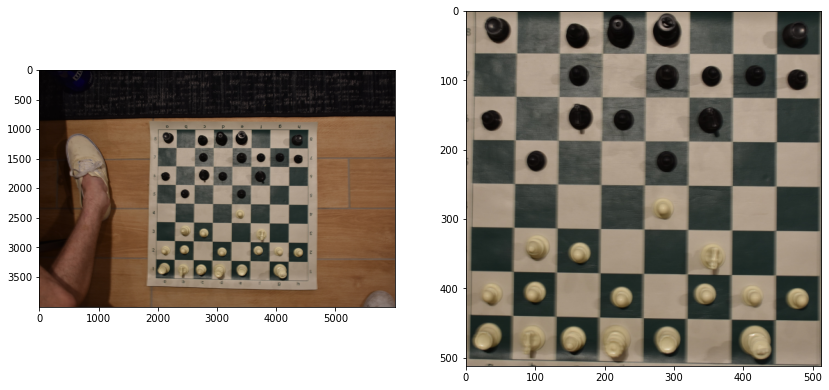

In [8]:
# read and resize the image
image = imageio.imread('./input/chess-dataset-master/labeled_originals/r1bqk2r-2p1bppp-p1np1n2-1p2p3-4P3-1BP2N2-PP1P1PPP-RNBQR1K1.JPG')
w, h = image.shape[0], image.shape[1]
if w < h:
    w, h = 1500, int(1500 * w / h)
else:
    w, h = int(1500 * h / w), 1500
#image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
board = preprocess(image)
cropped = crop_image(image, board)
cropped = cv2.resize(cropped, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(cropped)

# Batch Preprocessing

In [ ]:
# Preprocess all images of the dataset (first using the chess-dataset)
os.makedirs('preprocessed', exist_ok=True)
failed = []
for filename in tqdm(list(glob('input/chess-dataset-master/labeled_originals/*'))):
  image = imageio.imread(filename)
  w, h = image.shape[0], image.shape[1]
  if w < h:
    w, h = 1500, int(1500 * w / h)
  else:
    w, h = int(1500 * h / w), 1500
  #image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
  board = preprocess(image)
  if board is not None:
    cropped = crop_image(image, board)
    cropped = cv2.resize(cropped, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)
    imageio.imwrite(f'preprocessed/{Path(filename).stem}.jpg', cropped)
  else:
    failed.append(filename)

100%|██████████| 500/500 [12:24<00:00,  1.49s/it]


# Convolutional Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
pieces = {'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5, 'P': 6, 
          'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5, 'p': 6}
pieces_inv = {v: k for k, v in pieces.items()}
pieces_inv[0] = '-'
label_cnt = int(max(pieces.values())) + 1
weights = [1.0 if k == 0 else 4.0 if k % 6 == 0 else 8.0 for k in range(label_cnt)]
weights = np.array(weights)
weights /= np.max(weights)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)

def get_vector_by_fen(filename):
  filename = filename.replace('-', '/')
  vec = np.zeros((8, 8), dtype=np.int32)

  rank, col = 0, 0
  for c in filename:
    if c == '/':
      rank += 1
      col = 0
    elif c.isdigit():
      col += ord(c) - ord('0')
    elif c in pieces:
      vec[rank, col] = pieces[c]
      col += 1
    else:
      break
  return vec

def vector_to_class(y):
  shape = y.shape
  y = y.reshape(-1)
  out = np.zeros_like(y, dtype=str)
  for i in range(y.shape[0]):
    out[i] = pieces_inv[y[i]]
  return out.reshape(shape)

In [ ]:
class ChessboardLayer(keras.layers.Layer):
  def __init__(self, **kwargs):
    kwargs['trainable'] = False
    kwargs['dynamic'] = True
    super().__init__(**kwargs)

  def call(self, inputs, *args, **kwargs):
    # input shape = batch, row, column, channels
    # output shape = batch, 8, 8, -1
    batch, row, column, channel = inputs.shape
    batch_spl = tf.split(inputs, batch, axis=0)
    for idx in range(len(batch_spl)):
      row_spl = tf.split(batch_spl[idx], 8, axis=1)
      for i in range(len(row_spl)):
        cow_spl = tf.split(row_spl[i], 8, axis=2)
        for j in range(len(cow_spl)):
          cow_spl[j] = tf.reshape(cow_spl[j], (1, 1, 1, -1))
        row_spl[i] = tf.concat(cow_spl, axis=1)
      batch_spl[idx] = tf.concat(row_spl, axis=2)
    out = tf.concat(batch_spl, axis=0)
    return out

  def compute_output_shape(self, input_shape):
    batch, row, column, channel = input_shape
    return tf.TensorShape((batch, 8, 8, row * column * channel // 64))
    # batch, 8, 8, row * column * channel // 64

In [ ]:
class ImageDataset(keras.utils.Sequence):
  def __init__(self, filenames, batch_size, add_binary=False):
    self.filenames = filenames
    self.batch_size = batch_size
    self.add_binary = add_binary

  def __len__(self):
    return len(self.filenames) // self.batch_size
    
  def __getitem__(self, idx):
    X = np.zeros((self.batch_size, INPUT_SIZE, INPUT_SIZE, 3))
    y = np.zeros((self.batch_size, 64), dtype=np.int32)
    idx *= self.batch_size
    for i in range(self.batch_size):
      image = imageio.imread(self.filenames[idx + i]) / 256
      img_size = max(image.shape[0], image.shape[1])
      if img_size != INPUT_SIZE:
        image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)
      X[i, :, :] = image
      y[i] = get_vector_by_fen(Path(self.filenames[idx + i]).stem).reshape(-1)
    if self.add_binary:
      y_b = np.zeros_like(y)
      y_b[y > 0] = 1
      return X, (y, y_b)
    else:
      return X, y

In [ ]:
def weighted_loss(y_true, y_pred):
  loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
  indices = tf.reshape(y_true, shape=(-1,))
  sample_weigth = tf.reshape(tf.gather(weights, indices), shape=loss.shape)
  return sample_weigth * loss

In [ ]:
def load_model(filename):
  return keras.models.load_model(filename, {'ChessboardLayer': ChessboardLayer, 'weighted_loss': weighted_loss})

In [ ]:
keras.backend.clear_session()

if LOAD is None:
  image_in = keras.Input(shape=(INPUT_SIZE, INPUT_SIZE, 3))
  x = image_in

  for _ in range(CONV_CNT):
    x = layers.Conv2D(8, FILTER_SIZE, padding='same', activation='relu')(x)

  x = ChessboardLayer()(x)

  x = layers.Dense(32, activation='relu')(x)

  x1 = layers.Dense(label_cnt, activation='softmax')(x)

  out1 = layers.Reshape((64, label_cnt), name='out1')(x1)

  model = keras.Model(inputs=image_in, outputs=[out1])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0025),
      loss={'out1': weighted_loss, }, # 'out2': keras.losses.BinaryCrossentropy()
      metrics={'out1': keras.metrics.SparseCategoricalAccuracy(), } # 'out2': keras.metrics.BinaryAccuracy()
  )
elif isinstance(LOAD, str):
  model = load_model(LOAD)
elif isinstance(LOAD, (list, tuple)):
  model = [load_model(filename) for filename, weight in LOAD]

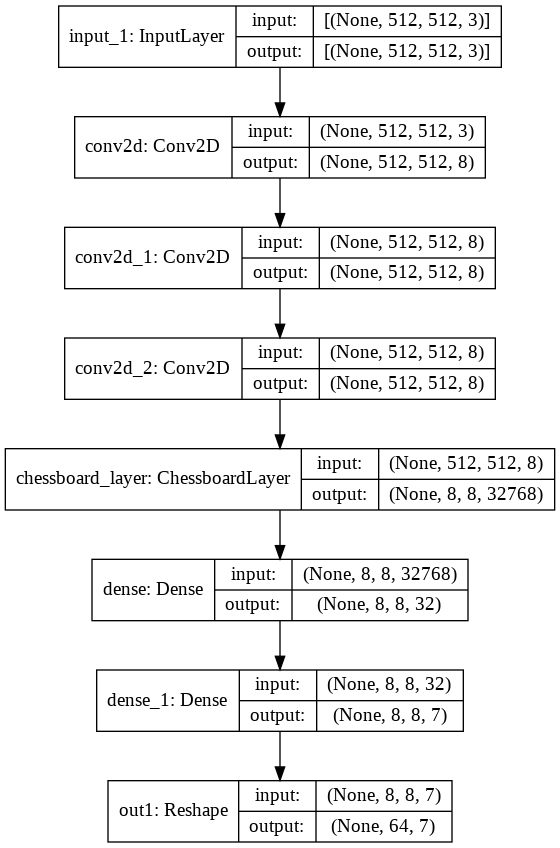

In [ ]:
keras.utils.plot_model(model, show_shapes=True) if isinstance(model, keras.Model) else None

In [ ]:
filenames = list(glob('preprocessed/*'))
random.shuffle(filenames)
test_size = len(filenames) % 8 + 16
dataset = ImageDataset(filenames[test_size:], 8)
X_test, y_test = ImageDataset(filenames[:test_size], test_size)[0]

In [ ]:
if LOAD is None:
  callbacks = [keras.callbacks.ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5')]
  model.fit(dataset, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)

In [ ]:
if isinstance(model, list):
  y_pred_all = np.zeros((test_size, 64, label_cnt))
  for i, m in enumerate(model):
    y_pred_all += m.predict(X_test) * LOAD[i][1]
else:
  y_pred_all = model.predict(X_test)
y_pred = np.argmax(y_pred_all, axis=2)

In [ ]:
class_pred = vector_to_class(y_pred)
class_true = vector_to_class(y_test)

In [ ]:
def plot_idx(ax, idx):
  score = 0
  for i in range(8):
    for j in range(8):
      p, t = class_pred[idx, j * 8 + i], class_true[idx, j * 8 + i]
      color = 'red'
      if p == t:
        color = 'blue'
        score += 1
      elif p != '-' != t:
        color = 'yellow'
        score += 0.5
      ax.text((i + 0.25) * (INPUT_SIZE // 8), (j + 0.5) * (INPUT_SIZE // 8), p, color=color, size='xx-large')
  ax.imshow(X_test[idx])
  ax.title.set_text(f'{score:.1f}/64')
  return score

752.0


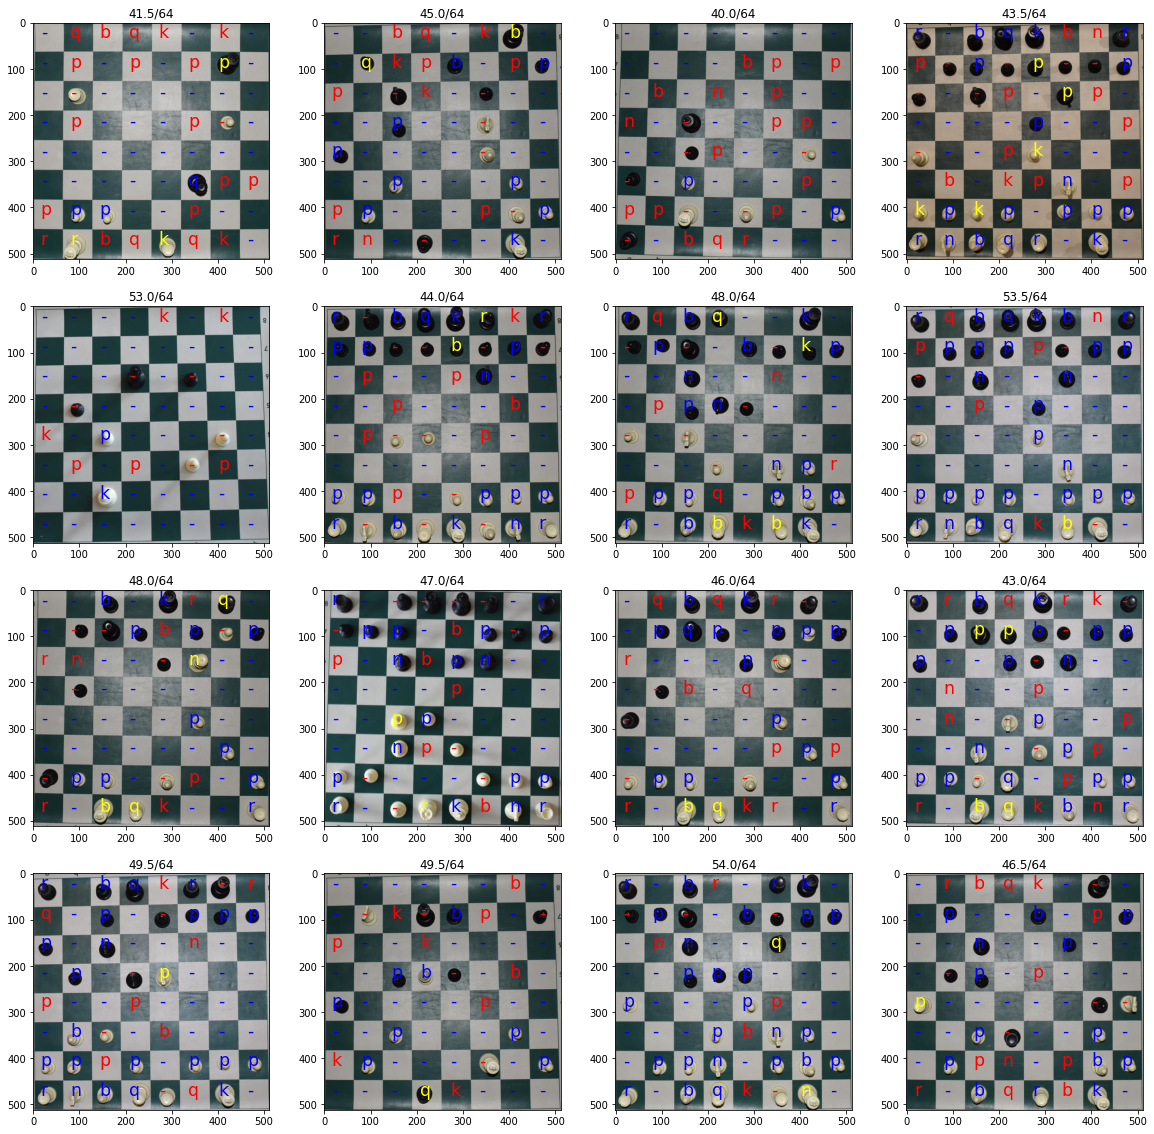

In [ ]:
row, col = (test_size + 3) // 4, 4
fig, axs = plt.subplots(row, col, figsize=(5 * col, 5 * row))
axs = [ax for ax_list in axs for ax in ax_list]
score = 0
for i in range(test_size):
  score += plot_idx(axs[i], i)
print(score)